In [1]:
import torch
import torch.nn as nn
import os 
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
ROOT_DATA_DIR = "/workspace/resnet/data/raw"
DATA_DIR = os.path.join(ROOT_DATA_DIR)#, "labelme-12-50k")
CLASSES_TXT_PATH = os.path.join(DATA_DIR, "classes.txt")


num_classes = 12
learning_rate = 0.001
num_epochs = 3
batch_size = 64
patience = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(CLASSES_TXT_PATH) as file:
    class_map_s2i = {line.rstrip():i for i, line in enumerate(file.readlines()) if line.rstrip()}
class_map_i2s = {v:k for k,v in class_map_s2i.items()}

INTERIM_DATA_DIR = "/workspace/resnet/data/interim/"

ROOT_DIR = "/workspace/resnet/"
MODEL_DIR = os.path.join(ROOT_DIR, "models")
CNN_PATH = os.path.join(MODEL_DIR, "2.0_cnn-balanced")

In [2]:
class_map_i2s

{0: 'person',
 1: 'car',
 2: 'building',
 3: 'window',
 4: 'tree',
 5: 'sign',
 6: 'door',
 7: 'bookshelf',
 8: 'chair',
 9: 'table',
 10: 'keyboard',
 11: 'head'}

In [3]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        # input channels is 3 because of RGB channels
        #((w-f+2P)/s) + 1
#         self.conv_l1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
#         self.conv_l2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3)
        self.conv_l1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.conv_l2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.conv_l3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
#         self.conv_l4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.conv_l3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv_l4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_l5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.conv_l6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.conv_l5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
#         self.conv_l6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
#         self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(50176,128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128,num_classes)
        
    def forward(self,x):
#         print(x.size())
        out = self.conv_l1(x)
#         print(out.size())
        out = self.conv_l2(out)
#         print(out.size())
        out = self.max_pool1(out)
#         print(out.size())
        out = self.conv_l3(out)
#         print(out.size())
        out = self.conv_l4(out)
#         print(out.size())
        out = self.max_pool2(out)
    
        out = self.conv_l5(out)
#         print(out.size())
        out = self.conv_l6(out)
#         print(out.size())
        out = self.max_pool2(out)
#         print(out.size())
        out = out.reshape(out.size(0), -1)
        
#         print(out.size())
        out = self.fc1(out)
#         print(out.size())
        out = self.relu1(out)
#         print(out.size())
        out = self.fc2(out)
        return out

In [4]:
train_df_balanced = pd.read_csv(os.path.join(INTERIM_DATA_DIR,"balanced-train-40000.csv"))
test_df = pd.read_csv(os.path.join(INTERIM_DATA_DIR,"test-10000.csv"))

In [5]:
transform = transforms.Compose(
            [transforms.ToTensor()
             ,transforms.Normalize((0.5,0.5,0.5),(0.5, 0.5, 0.5))
            ]
            )

In [6]:
class MyDataset(Dataset):
    def __init__(self,annot_df,transform = None):
        self.annotations = annot_df
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img = Image.open(self.annotations.img_path[index])
        y_label = torch.tensor(int(self.annotations.int_label[index]))
        if self.transform:
            image = transform(img)
        else:
            image = img
        return (image,y_label)

In [7]:
# train_data = MyDataset(train_df,transform = transform)
test_data = MyDataset(test_df,transform = transform)
train_data_balanced = MyDataset(train_df_balanced,transform = transform)


# train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
train_loader_balanced = DataLoader(dataset = train_data_balanced, batch_size = batch_size, shuffle = True)

test_loader

In [8]:
model = CNN(12)
model.load_state_dict(torch.load(CNN_PATH))
model.eval()

CNN(
  (conv_l1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_l2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_l3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_l4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_l5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_l6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTION: person
ACTUAL: person


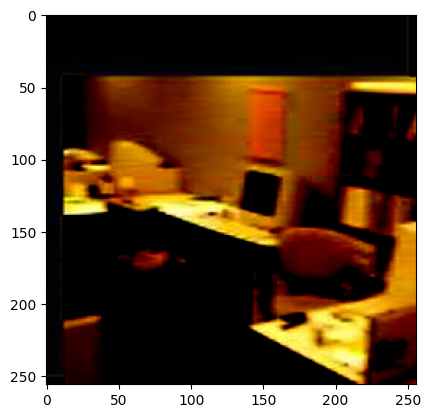

In [9]:
torch_test_df = test_loader.dataset #test_loader.dataset
n_samples = len(torch_test_df)



# Get a random sample
random_index = int(np.random.random()*n_samples)
# single_example = torch_test_df[random_index]
# single_example = torch_test_df.sample(64)

# label, image = next(iter(single_example))
# Image.open(image)
# print(class_map_i2s[int(single_example[1].numpy())])
# plt.imshow(single_example[0].permute(1, 2, 0))
import numpy as np
your_list = list(np.random.permutation(np.arange(0,len(torch_test_df)))[:64])
trainset_1 = torch.utils.data.Subset(torch_test_df, your_list)
(trainset_1[63][0].shape)
images = torch.stack([i[0] for i in trainset_1])#.shape
labels = torch.stack([i[1] for i in trainset_1])
print(labels[0])
type(images)
images = images
# plt.imshow(transforms.ToPILImage()(images))#, interpolation="bicubic")
with torch.no_grad():
#     images = images.to(device)
#     print(images.shape)
    outputs = model((images))#model(images)
#     print(torch.max(outputs.data,1)[0])
#     print(.shape)
    #[0][0])
    plt.imshow(images[0].permute(1, 2, 0))
    print(f'PREDICTION: {class_map_i2s[int(torch.argmax(outputs.data,1)[0].int())]}')
    print(f'ACTUAL: {class_map_i2s[int(labels[0])]}')
    
    

# single_example[0]

In [10]:
summary(CNN(12),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
            Conv2d-2         [-1, 32, 252, 252]           9,248
         MaxPool2d-3         [-1, 32, 126, 126]               0
            Conv2d-4         [-1, 64, 124, 124]          18,496
            Conv2d-5         [-1, 64, 122, 122]          36,928
         MaxPool2d-6           [-1, 64, 61, 61]               0
            Conv2d-7           [-1, 64, 59, 59]          36,928
            Conv2d-8           [-1, 64, 57, 57]          36,928
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Linear-10                  [-1, 128]       6,422,656
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 12]           1,548
Total params: 6,563,628
Trainable params: 6,563,628
Non-trainable params: 0
---------------------------

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
#         print(type(images))
#         print(images.shape)
#         print(images)
        outputs = model(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
#         print(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels.size(0))
        print((predicted == labels).sum().item())
        print("-------------------")
        end
    
    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))




In [ ]:
predicted[0]

In [ ]:
labels[0]

In [ ]:
images[0]

In [ ]:
plt.imshow(transforms.ToPILImage()(images[0]), interpolation="bicubic")

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
images

In [ ]:
torch_test_df = test_loader.dataset
n_samples = len(torch_test_df)

# Get a random sample
random_index = int(np.random.random()*n_samples)
single_example = torch_test_df[random_index]
# label, image = next(iter(single_example))
# Image.open(image)
print(class_map_i2s[int(single_example[1].numpy())])
# plt.imshow(single_example[0].permute(1, 2, 0))
plt.imshow(transforms.ToPILImage()(single_example[0]), interpolation="bicubic")
with torch.no_grad():
    images = single_example[0].to(device)
    outputs = model(images)
    print(outputs)

# single_example[0]

In [ ]:
images, labels = next(iter(test_loader))
images[1].shape